In [1]:
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

from utils.conn_data import load_pickle

plt.style.use('ggplot')

In [2]:
models = [
    'spectrum',
    'sdne_20_1_1', 'sdne_30_1_1', 'sdne_40_1_1', 'sdne_50_1_1', 'sdne_100_1_1', 'sdne_100_5_5', 'sdne_100_10_10', 'sdne_100_15_15', 'sdne_100_20_20',
]
datasets = ['simulation1']
outputs_path = os.path.join(os.getcwd(), 'data', 'outputs')

## Check all Model Prediction Errors

In [6]:

prediction_error = []
for model in models:
    for ds in datasets:

        # load data
        data = load_pickle(os.path.join(outputs_path, ds, model, 'results.pkl'))

        try:
            # compute relevant metrics
            mse = mean_squared_error(data['true'], data['pred'])
            mae = mean_absolute_error(data['true'], data['pred'])

            # store results
            prediction_error.append({"model": model, "dataset": ds, "mse": mse, "mae": mae})
        except:
            print(f'Error for {model} on {ds}')

prediction_error_df = pd.DataFrame(prediction_error)

Error for spectrum on simulation1
Error for sdne_20_1_1 on simulation1
Error for sdne_30_1_1 on simulation1
Error for sdne_40_1_1 on simulation1
Error for sdne_50_1_1 on simulation1
Error for sdne_100_1_1 on simulation1
Error for sdne_100_5_5 on simulation1
Error for sdne_100_10_10 on simulation1
Error for sdne_100_15_15 on simulation1
Error for sdne_100_20_20 on simulation1


## Check Individual Model

In [15]:
model = 'spectrum'
ds = 'simulation1'

# load data
data = load_pickle(os.path.join(outputs_path, ds, model, 'results.pkl'))

try:
    # compute relevant metrics
    mse = mean_squared_error(data['true'], data['pred'])
    mae = mean_absolute_error(data['true'], data['pred'])

    # store results
    prediction_error.append({"model": model, "dataset": ds, "mse": mse, "mae": mae})
except:
    print(f'Error for {model} on {ds}')

pred_df = pd.DataFrame({'pred': data['pred'], 'true': data['true']})

# find nans
nan_rows = pred_df[pred_df.isnull().any(1)]

# get embeddings from nan position
nan_embeddings = data['embeddings'][nan_rows.index]

# # get inputs from nan position
# nan_inputs = data['inputs'][nan_rows.index]


Error for spectrum on simulation1


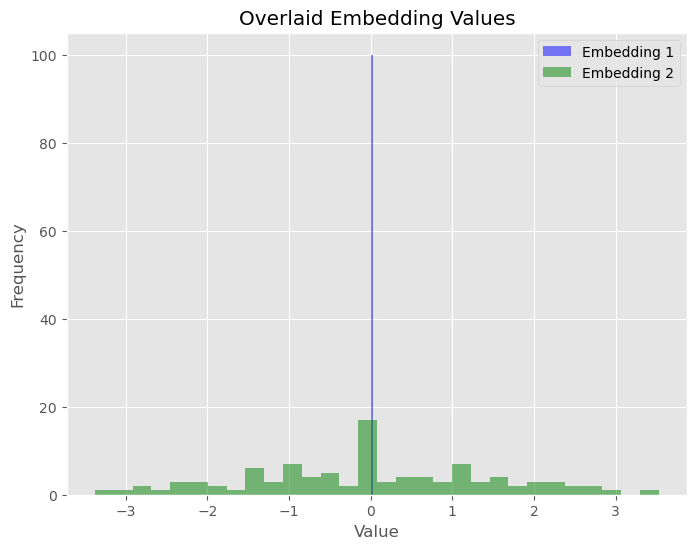

In [14]:
embedding_pos = 10

selected_embedding_df = pd.DataFrame(nan_embeddings[0, :, :].numpy()).T

# Create the plot
plt.figure(figsize=(8, 6))

# Plotting the histograms
plt.hist(selected_embedding_df[[0]], bins=30, color='blue', alpha=0.5, label='Embedding 1')
plt.hist(selected_embedding_df[[1]], bins=30, color='green', alpha=0.5, label='Embedding 2')

# Adding titles and labels
plt.title('Overlaid Embedding Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Adding a legend
plt.legend()